In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, scan, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-05-16 16:20:37,500][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-05-16 16:20:37,548][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.0'

1. Get latest dataset from Natasha from database
2. load 2p movie to array. 
3. load top-video to array
4. find the Start and end frames of the movie with respect to the tracking gate 

In [2]:
import bisect
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import concurrent.futures
import cv2

def get_closest_timestamps(series, target_timestamp):
    # List to store the indices
    indices = []

    # For each timestamp in series1, find the closest timestamp in series2 and get its index
    for t1 in series:
        closest_index = closest_timestamp(target_timestamp, t1)
        indices.append(closest_index)
    return indices

# Function to find closest timestamp
def closest_timestamp(series, target_timestamp):
    index = bisect.bisect_left(series, target_timestamp)
    if index == 0:
        return 0
    if index == len(series):
        return len(series)-1
    before = series[index - 1]
    after = series[index]
    if after - target_timestamp < target_timestamp - before:
       return index
    else:
       return index-1


def resize_movie(movie, new_height, new_width):
    # Get the number of frames and color channels
    num_frames, _, _, num_channels = movie.shape
    
    # Initialize an empty array for the scaled movie
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)
    
    # Iterate through each frame
    for i in tqdm(range(num_frames), desc="Resizing frames"):
        # Resize the frame and store it in the new array
        scaled_movie[i] =  cv2.resize(movie[i], (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    # Return the scaled movie
    return scaled_movie


def resize_frame(frame, new_height, new_width):
    return cv2.resize(frame, (new_width, new_height), interpolation = cv2.INTER_AREA)

def resize_movie_mt(movie, new_height, new_width):
    num_frames, _, _, num_channels = movie.shape
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, resized_frame in tqdm(enumerate(executor.map(resize_frame, movie, [new_height]*num_frames, [new_width]*num_frames)), total=num_frames, desc="Resizing frames"):
            scaled_movie[i] = resized_frame

    return scaled_movie


import numpy as np
from skimage.transform import resize
import concurrent.futures



In [3]:
# defining queries - example for latest recording sessino of specific user

# select user
user = "NK"
userquery = (session.SessionUser * subject.User() & f'initials = "{user}"')


# get the latest session
usesession = session.Session.fetch(order_by='session_datetime DESC', as_dict=True)[0]["session_id"]
sessionquery = session.Session &  f'session_id = "{usesession}"'

scansi = (scan.Scan & sessionquery).fetch('scan_id')[0]

scanquery = scan.Scan & f'scan_id = "{scansi}"'


In [4]:
# defining queries - example for directly giving scan number


scansi = "scan9FHS7Y22"

scanquery = scan.Scan & f'scan_id = "{scansi}"'


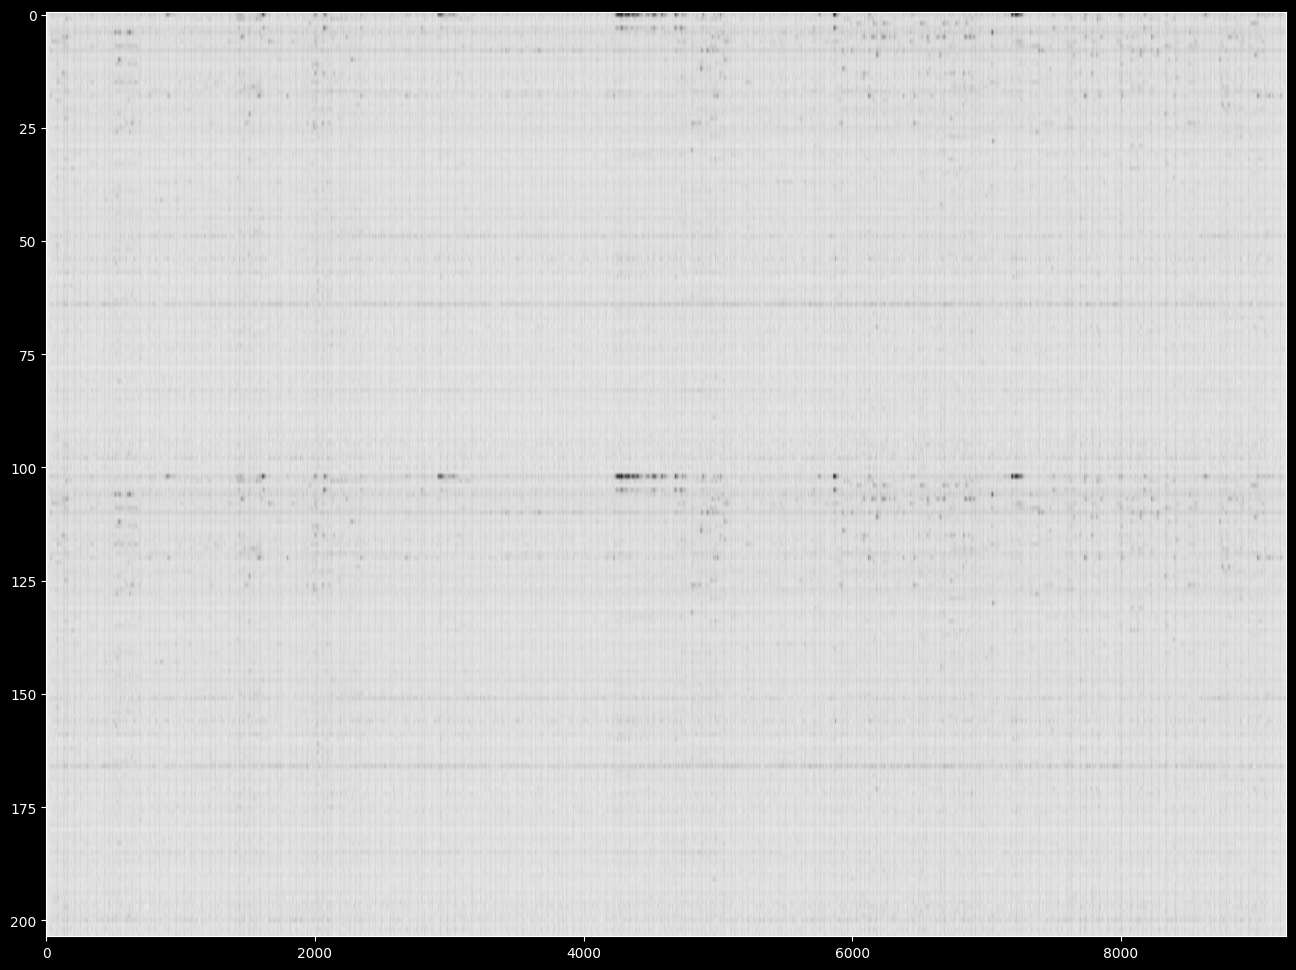

In [5]:
fluos = np.vstack((scanquery * imaging.Fluorescence.Trace).fetch("fluorescence"))
plt.figure(figsize=(16,12))
plt.imshow(fluos, aspect='auto', cmap='gray_r')

### MOVIES

In [6]:
from pathlib import Path
import skvideo.io

# get the main data directory of the specified scanID 

dir = (scan.ScanPath & scanquery).fetch('path')

# get the top cam movie of that session
directory = Path(dir[0])
pattern = '*top_video*.mp4'
files = list(directory.glob(pattern))

#load to array
videodata = skvideo.io.vread(str(files[0]))
videodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in videodata], dtype=np.uint8)

In [7]:
# get the registered moving average (blinking) movie data of the specified scanID
directory = Path(dir[0] + "/suite2p/plane0/reg_tif")
pattern = '*40_frame*.mp4'
files = list(directory.glob(pattern))
blinkvideodata = skvideo.io.vread(str(files[0]))
blinkvideodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in blinkvideodata], dtype=np.uint8)

#dimensionts of the original movie (frames, x,y,rgb)
print(videodata.shape)
print(blinkvideodata.shape)

(36157, 1000, 1000, 3)
(9230, 256, 256, 3)


In [8]:
# display camaravideo with slider
sh.display_volume_z(videodata,1)

interactive(children=(IntSlider(value=0, description='z', max=36156), Output()), _dom_classes=('widget-interac…

In [9]:
# display 2pstackvideo with slider
sh.display_volume_z(blinkvideodata,1)

interactive(children=(IntSlider(value=0, description='z', max=9229), Output()), _dom_classes=('widget-interact…

#### Synchronization!

In [10]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scanquery).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scanquery ).fetch('event_start_time')

#  Zero camera timestamps on first 2p timestamp.
cameratimestamps = cameratimestamps - twoptimestamps[0]

In [11]:
(event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scanquery).fetch('event_start_time')

array([  2.03335,   2.05   ,   2.06665, ..., 602.6    , 602.617  ,
       602.633  ])

In [12]:
# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))

# now use this camara frame indices to reslice the video (which now is aligned to the 2p frames on a frame-by-frame level)
resliced_cam_video = videodata[aligned_cameraframes]

In [13]:
# display synchronized movie
sh.display_volume_z(resliced_cam_video,1)

interactive(children=(IntSlider(value=0, description='z', max=9229), Output()), _dom_classes=('widget-interact…

In [16]:
# rescale camera movie to fit size of 2p movie (can take a lot of time and memory)
rescaled_cam_movie = resize_movie(resliced_cam_video, np.shape(blinkvideodata)[1],np.shape(blinkvideodata)[2])

Resizing frames: 100%|██████████| 9230/9230 [00:40<00:00, 226.29it/s]


In [17]:
# concatenate and display movies
concatmovie = np.concatenate((blinkvideodata,rescaled_cam_movie), axis = 2)
sh.display_volume_z(concatmovie,1)

interactive(children=(IntSlider(value=0, description='z', max=9229), Output()), _dom_classes=('widget-interact…

In [18]:
#save as new movie (without rescaling)


filename = str(directory) + '/aligned_stack_cam_movie.mp4'
fps = (scan.ScanInfo & scanquery).fetch('fps')
# p1 = 0
# p2 = 100
# trash = sh.make_stack_movie(concatmovie, filename, fps[0], p1, p2)

codecset = 'libx264'
import imageio
import imageio.plugins.ffmpeg as ffmpeg

# Create an imageio VideoWriter object to write the video
writer = imageio.get_writer(filename, fps=fps[0], codec=codecset, output_params=['-crf', '19'])

# # Calculate the 1st and 99th percentile
# p1, p99 = np.percentile(running_z_projection[:500,:,:], (p1set, p2set))

# # rescale to 8 bit
# rescaled_image_8bit = rescale_image_multithreaded(running_z_projection, p1, p99)

for page in concatmovie:
    writer.append_data(page)

# Close the video writer
writer.close()


In [19]:
# speed up, add timestamps etc - all with fast ffmpeg operations

import os

spedby = 5
setpts_value = 1/spedby # change this to your desired value
newfps = fps[0]*spedby

input_filename = filename
# 2. Add timestamps

output_filename = str(directory) + '/' + scansi + '_top_video_concatenated' + 'withtimestamps.mp4'
command = f"""ffmpeg -y -i {input_filename} -vf "drawtext=fontfile=/Library/Fonts/Arial.ttf:timecode='00\\\\:00\\\\:00\\\\:00':rate={fps[0]}:text='':fontsize=14:fontcolor=white:x=270:y=10:box=1:boxcolor=0x00000000@1" -f mp4 {output_filename}"""

os.system(command)


input_filename = output_filename  # 'sped_up_video.mp4'
output_filename = str(directory) + '/' +  scansi + '_top_video_concatenated_spedup_' + str(spedby) + 'fold_withtimestamps.mp4'

command = f'ffmpeg -y -i {input_filename} -vf "setpts={setpts_value}*PTS" -r {newfps}  {output_filename}'



os.system(command)


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

0

### IMU